In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

In [2]:
#input_dir = 'output-files-bootstrap-test7-2d'

#input_dir = 'output-files-bootstrap-test6b-2d-2a-100k'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-v1b'

#input_dir = 'output-files-bootstrap-test6b-2d-2a'




#input_dir = 'bootstrap-toy-study6b-2d-4c'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-4c'



#input_dir = 'freshtoys-simple-pdf-toy-study6b-2d-4c'

#input_dir = 'freshtoys-toy-study6b-2d-4c'



#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model'

#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model/freshmc-01'
#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model/freshmc-02'




#input_dir = 'bootstrap-toy-study6b-1d-1a'
#input_dir = 'bootstrap-toy-study6b-1d-1a-badres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-goodres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-verygoodres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-perfect'

#input_dir = 'bootstrap-toy-study6b-1d-1a-nb1000'


#input_dir = 'simple-pdf-toy-study6b-1d-1a-1k'



#input_dir = 'fit-pdf-toy-study-2d-1a'

#input_dir = 'fit-pdf-toy-study-1d-1a'

#input_dir = 'hist-pdf-toy-study-1d-1b'

#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution-5k-toys'


#input_dir = 'bootstrap-toy-study8a-1d-1c'

#input_dir = 'hist-pdf-toy-study-1d-1a-perfect'
#input_dir = 'hist-pdf-toy-study-1d-1a-goodres'
#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-1a-badres'



#input_dir = 'bootstrap-toy-study8a-1d-1d'

#input_dir = 'bootstrap-toy-study8a-1d-1d-gpu0'

#input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'

#-----



#input_dir = 'hist-pdf-toy-study-1d-1a-perfect'
#input_dir = 'hist-pdf-toy-study-1d-1a-goodres'
#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-1b-mediumbad'


#input_dir = 'bootstrap-toy-study8a-1d-1d-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-1d'
input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'
#input_dir = 'bootstrap-toy-study8a-1d-1d-gpu0'








with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (100000, 1)
 shape of true_pts:   (10000, 1)





In [3]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [4]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 1




In [5]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

<function matplotlib.pyplot.show(close=None, block=None)>

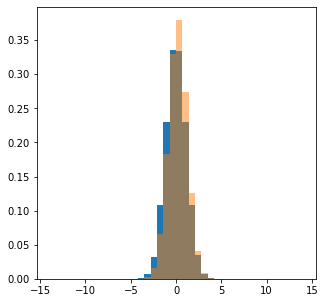

In [6]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))



hmin=-5
hmax=5


hmin=-14
hmax=14

hbins=40


for i in range(ndim) :
    if ndim > 1 :
        thisax = ax[i]
    else :
        thisax = ax
    thisax.hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
    thisax.hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

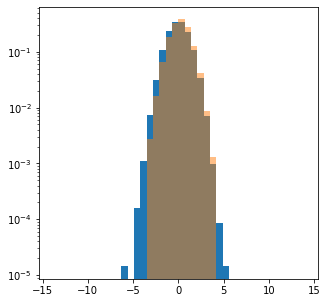

In [7]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins=40


for i in range(ndim) :
    if ndim > 1 :
        thisax = ax[i]
    else :
        thisax = ax
    thisax.hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
    thisax.hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    thisax.set_yscale('log')
    
plt.show

In [8]:
with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)


In [9]:
main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

<function matplotlib.pyplot.show(close=None, block=None)>

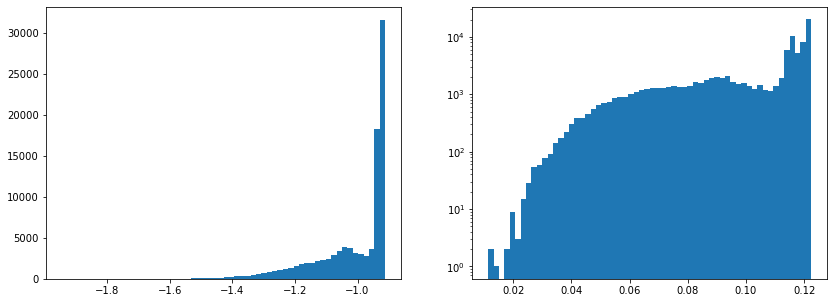

In [10]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(main_sample_omnifold_weights), bins=hbins)
ax[1].hist( main_sample_omnifold_weights, bins=hbins)
ax[1].set_yscale('log')
plt.show

In [11]:
true_rho

array([[0.]])

In [12]:
true_mu.shape

(1,)

In [13]:
true_cov = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        k = ndim - j - 1
        if i == j :
            true_cov[i][j] = true_sig[i]*true_sig[i]
        elif j > i :
            print(" %d, %d, %d" % (i,j,k))
            true_cov[i][j] = true_rho[i][k] * true_sig[i] * true_sig[j]

In [14]:
true_cov

array([[0.81]])

In [15]:
have_fits = False

if exists( "%s/fit-results.npy" % input_dir ) :
    have_fits = True
    print("\n\n Have fit results file.\n\n")



 Have fit results file.




In [16]:
if have_fits :
    
    with open( '%s/fit-results.npy' % input_dir, 'rb' ) as f :
        fit_results_mean_val = np.load(f, allow_pickle=True )
        fit_results_mean_err = np.load(f, allow_pickle=True )
        fit_results_cov_val = np.load(f, allow_pickle=True )
        fit_results_cov_err = np.load(f, allow_pickle=True )        
        

    ave_fit_err_mean = np.zeros( ndim )
    
    ave_fit_err_cov = np.zeros( shape=(ndim,ndim) )

    for fi in range(ndim) :
    
        ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])
        
        print( '%d : ave fit error, mean :  %8.4f' % (fi, ave_fit_err_mean[fi]))
        
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            
            
            ave_fit_err_cov[fi1,fi2] = np.mean( fit_results_cov_err[fi1,fi2,:])
            
            print( 'fi1, fi2 : %d, %d    ave fit error, cov : %8.4f' % (fi1,fi2, ave_fit_err_cov[fi1,fi2]))
    

0 : ave fit error, mean :    0.0090
fi1, fi2 : 0, 0    ave fit error, cov :   0.0115


In [17]:
def calc_mean( weights, fi ) :
    
    mean = ( np.sum( weights * train_pts[:,fi]) ) / ( np.sum( weights ) )
    
    return mean

In [18]:
def calc_rms( weights, fi ) :
    
    x = calc_mean( weights, fi )
    xx = ( np.sum( weights * train_pts[:,fi] * train_pts[:,fi] ) ) / ( np.sum( weights ) )
    
    #print(" x = %f,  xx = %f" % (x, xx))
    
    return np.sqrt(xx - x*x)


In [19]:
def calc_cov( weights, fi1, fi2 ) :
    
    x1 = calc_mean( weights, fi1 )
    x2 = calc_mean( weights, fi2 )
    x1x2 = ( np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] ) ) / ( np.sum( weights ) )
    
    return np.sqrt( x1x2 - x1*x2 )
    

In [20]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [21]:
n_samples = 0

for fi in range(5000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 1000 bootstrap samples.




In [22]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )


si = 0

for fi in range(5000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            print( len(final_push_weights_scaled))
            print( final_push_weights_scaled )
            print( true_pts[:,0])
            
            all_weight_min[si] = np.min( final_push_weights_scaled )
            all_weight_max[si] = np.max( final_push_weights_scaled )
            
            for fi1 in range(ndim) :
                for fi2 in range(fi1,ndim) :
                    mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                    all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                    all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                    if ( fi1 == fi2 ) :
                        print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                              (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                        all_mean[fi1,si] = mean_cov["mean_x1"]
                        all_rms[fi1,si] = mean_cov["rms1"]
                    else :
                        print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                              (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                        all_rho[fi1,fi2,si] = mean_cov["rho12"]
                        all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-000.npy exists
100000
[0.0908542  0.10313333 0.10109524 ... 0.11802605 0.12085155 0.10389022]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1852, RMS =   0.8977, cov =   0.8060

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-001.npy exists
100000
[0.09335078 0.10830018 0.10549019 ... 0.11895775 0.12018222 0.10731739]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1994, RMS =   0.9009, cov =   0.8116

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-002.npy exists
100000
[0.09240772 0.10630647 0.10654791 ... 0.12102346 0.12099708 0.10777   ]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1938, RMS =   0.8974, cov =   0.8054

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-003.npy exists
1000

  0 0  :  mean =   0.2066, RMS =   0.8991, cov =   0.8084

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-180.npy exists
100000
[0.09391606 0.08730185 0.1057756  ... 0.12752766 0.12646221 0.11655308]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2143, RMS =   0.8948, cov =   0.8007

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-181.npy exists
100000
[0.09835554 0.10566995 0.10363758 ... 0.12290639 0.12685681 0.10200037]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1885, RMS =   0.8937, cov =   0.7987

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-182.npy exists
100000
[0.09470285 0.11680768 0.09441219 ... 0.12079026 0.12095314 0.0968191 ]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1966, RMS =   0.9191, cov =   0.8448

----- bootstrap-toy-study8a-1d-1

  0 0  :  mean =   0.1822, RMS =   0.9058, cov =   0.8206

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-213.npy exists
100000
[0.09969232 0.0970773  0.09959148 ... 0.1230067  0.1251766  0.09584526]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2011, RMS =   0.8861, cov =   0.7852

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-214.npy exists
100000
[0.09201014 0.09711563 0.1020767  ... 0.12212893 0.1235046  0.10358596]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2236, RMS =   0.8948, cov =   0.8007

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-215.npy exists
100000
[0.09405853 0.0961891  0.09797724 ... 0.12122958 0.12189156 0.09953315]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2092, RMS =   0.9100, cov =   0.8282

----- bootstrap-toy-study8a-1d-1

[0.09324403 0.10454229 0.10638496 ... 0.12886592 0.12910451 0.10487785]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2091, RMS =   0.9013, cov =   0.8124

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-403.npy exists
100000
[0.10093594 0.10756058 0.10713545 ... 0.1138407  0.11507988 0.10842984]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1735, RMS =   0.9083, cov =   0.8251

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-404.npy exists
100000
[0.10086671 0.10395567 0.10583164 ... 0.11921948 0.11995506 0.10262184]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2021, RMS =   0.8891, cov =   0.7906

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-405.npy exists
100000
[0.09314556 0.10068981 0.0969876  ... 0.12341753 0.12461805 0.09763023]
[-1.79700991 -0.820

[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2218, RMS =   0.9066, cov =   0.8220

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-436.npy exists
100000
[0.09679311 0.10453233 0.10675751 ... 0.11916637 0.12108033 0.10725277]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1874, RMS =   0.9007, cov =   0.8112

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-437.npy exists
100000
[0.0941366  0.11439752 0.10386101 ... 0.11998369 0.12123314 0.10486355]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2083, RMS =   0.8880, cov =   0.7886

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-438.npy exists
100000
[0.09562829 0.1134943  0.10552845 ... 0.11591077 0.11594344 0.10894795]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  me


----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-624.npy exists
100000
[0.09126812 0.11416031 0.09744167 ... 0.11841161 0.11949002 0.10374715]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1897, RMS =   0.8951, cov =   0.8012

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-625.npy exists
100000
[0.09188018 0.10991469 0.09681588 ... 0.12145112 0.12198954 0.10411137]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1957, RMS =   0.9038, cov =   0.8168

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-626.npy exists
100000
[0.09166739 0.10713788 0.08900511 ... 0.12239327 0.1245239  0.09054924]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1997, RMS =   0.9061, cov =   0.8209

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-627.npy exists
1000


----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-657.npy exists
100000
[0.09539981 0.11512691 0.10436271 ... 0.12026704 0.11968839 0.10552814]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2092, RMS =   0.9105, cov =   0.8290

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-658.npy exists
100000
[0.08831601 0.10656495 0.09714649 ... 0.11993713 0.12003341 0.10246912]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1935, RMS =   0.9106, cov =   0.8291

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-659.npy exists
100000
[0.09291432 0.10769218 0.09926535 ... 0.11952146 0.12077892 0.10075394]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2081, RMS =   0.8906, cov =   0.7932

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-660.npy exists
1000

100000
[0.09295708 0.11066807 0.10042471 ... 0.1132678  0.11551769 0.10356602]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1891, RMS =   0.8787, cov =   0.7721

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-848.npy exists
100000
[0.09799559 0.08673176 0.09764155 ... 0.1222466  0.12364714 0.09252589]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2040, RMS =   0.9127, cov =   0.8330

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-849.npy exists
100000
[0.09275487 0.10713805 0.10885042 ... 0.12031869 0.1221714  0.11466792]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1992, RMS =   0.8928, cov =   0.7972

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-850.npy exists
100000
[0.09312876 0.10485324 0.10955738 ... 0.12339287 0.12436178 0.11005037]
[-1.79700991


----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-880.npy exists
100000
[0.09712672 0.10422079 0.10169483 ... 0.12280482 0.125134   0.10257148]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2073, RMS =   0.9010, cov =   0.8117

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-881.npy exists
100000
[0.09507727 0.10333504 0.10132219 ... 0.12422976 0.12197316 0.10193831]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.1952, RMS =   0.9053, cov =   0.8195

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-882.npy exists
100000
[0.09575674 0.11240436 0.11015457 ... 0.12293265 0.12339025 0.10991647]
[-1.79700991 -0.82052055 -0.26066693 ... -0.78802975  0.22758367
 -0.81312809]
  0 0  :  mean =   0.2150, RMS =   0.8854, cov =   0.7840

----- bootstrap-toy-study8a-1d-1d-nominal-resolution/bootstrap-weights-883.npy exists
1000

In [23]:
all_mean

array([[0.18522928, 0.19935197, 0.19384983, 0.21699681, 0.18215437,
        0.22541858, 0.1920973 , 0.20621599, 0.20807491, 0.21402549,
        0.21591092, 0.18433946, 0.19336176, 0.21368062, 0.20106619,
        0.19675942, 0.20591084, 0.17188023, 0.21089034, 0.17680633,
        0.1981086 , 0.18606502, 0.20112873, 0.20467261, 0.19369402,
        0.21287225, 0.22343134, 0.20753669, 0.18570146, 0.15580358,
        0.21112313, 0.17413693, 0.2058703 , 0.20620666, 0.17761604,
        0.17982462, 0.19234846, 0.19075706, 0.19938176, 0.21004717,
        0.18784552, 0.20978276, 0.18765369, 0.19564776, 0.19458525,
        0.18311632, 0.2045325 , 0.1899343 , 0.180162  , 0.19055272,
        0.21188437, 0.2051514 , 0.1978952 , 0.18541467, 0.20393962,
        0.18707697, 0.18755572, 0.1769759 , 0.20746202, 0.20977561,
        0.17863704, 0.20465374, 0.20583041, 0.20328892, 0.17559686,
        0.21344319, 0.20132333, 0.1802655 , 0.21023319, 0.21547808,
        0.20613438, 0.19058864, 0.20170455, 0.22

<function matplotlib.pyplot.show(close=None, block=None)>

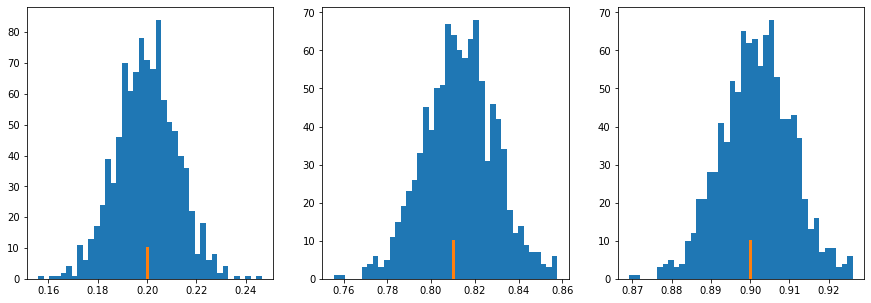

In [24]:
fig,ax = plt.subplots( ndim, 3, figsize=(3*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    thisax.hist( all_mean[i], bins=40)
    thisax.plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    thisax.hist( all_cov[i][i], bins=40)
    thisax.plot( (true_cov[i][i], true_cov[i][i]), (0,ymax), linewidth=3 )


    
    if ndim > 1 :
        thisax = ax[i][2]
    else :
        thisax = ax[2]    
    thisax.hist( all_rms[i], bins=40)
    thisax.plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

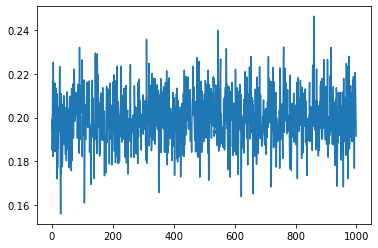

In [25]:
plt.plot(all_mean[0])
plt.show

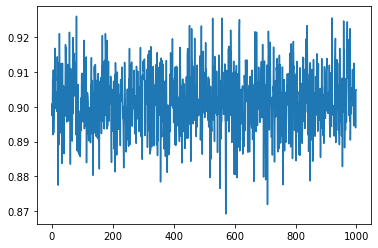

In [26]:
plt.plot(all_rms[0])

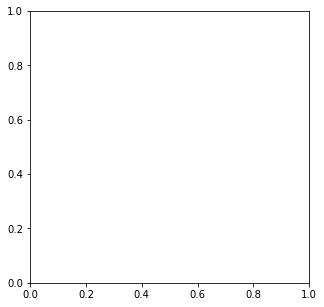

In [27]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5,ndim*5))

ymax = 10

if ndim > 1 :

    for i in range(0,ndim-1) :

        for j in range(i+1,ndim) :

            k = ndim - j - 1

            ax[i][j].hist( all_rho[i,j], bins=40)

            ax[i][j].plot( (true_rho[i][k], true_rho[i][k]), (0, ymax), linewidth=3 )



    plt.show

In [28]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )
rms_mean_err = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )
rms_cov_err = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    rms_mean_err[fi] = rms_mean[fi] / np.sqrt(2*n_samples)
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.4f +/- %6.4f" % 
          (fi, ave_mean[fi], true_mu[fi], rms_mean[fi], rms_mean_err[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        rms_cov_err[fi1,fi2] = rms_cov[fi1,fi2]/np.sqrt(2*n_samples)
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.4f +/- %6.4f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2], rms_cov_err[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.1998  (true   0.2000), rms   0.0122 +/- 0.0003


  feature 0  :  RMS    ave   0.9016  (true   0.9000), rms   0.0090




  feature 0, 0  :  cov    ave   0.8130  (true   0.8100), rms   0.0162 +/- 0.0004




## Save the simple direct calculation results for setting fit parameter ranges from RMS.

In [29]:
with open( '%s/simple-calc-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [30]:
all_mean.shape

(1, 1000)

In [31]:
fit_results_mean_val.shape

(1, 387)

In [32]:
n_for_plot = 0

n_boot = len(all_mean[0])
n_fit  = len(fit_results_mean_val[0])

if n_boot > n_fit :
    n_for_plot = n_fit
else :
    n_for_plot = n_boot

print('  n_boot = %d,   n_fit = %d,   n_for_plot = %d' % (n_boot, n_fit, n_for_plot))



  n_boot = 1000,   n_fit = 387,   n_for_plot = 387


   0 : x axis limits:  0.152, 0.240    y axis limits  0.152, 0.240


<function matplotlib.pyplot.show(close=None, block=None)>

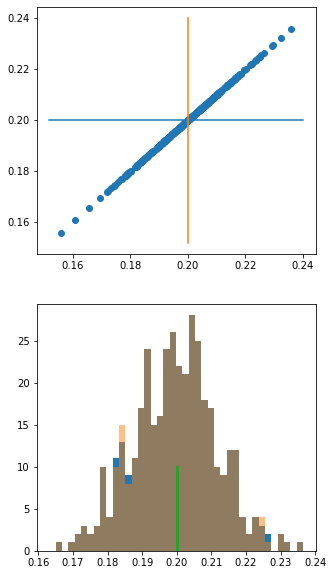

In [33]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    
    
    if ndim > 1 :
        thisax = ax[0][fi]
    else :
        thisax = ax[0]
        
    thisax.scatter( all_mean[fi,:n_for_plot], fit_results_mean_val[fi,:n_for_plot])
    xlow, xhigh = thisax.get_xlim()
    ylow, yhigh = thisax.get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    thisax.plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    thisax.plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    if ndim > 1 :
        thisax = ax[1][fi]
    else :
        thisax = ax[1]
    
    
    thisax.hist( fit_results_mean_val[fi,:n_for_plot], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.hist( all_mean[fi,:n_for_plot], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

In [34]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))
            ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

    plt.show

In [35]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    hbins=40
    hmax=10

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))

            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

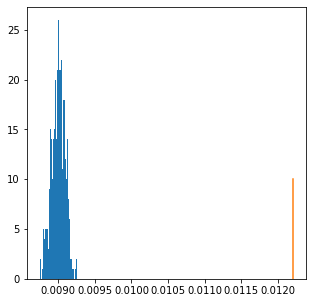

In [36]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    if ndim > 1 :
        thisax = ax[fi]
    else :
        thisax = ax
        
    thisax.hist( fit_results_mean_err[fi,:], bins=hbins )
    thisax.plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

In [37]:
fit_results_mean_err

array([[0.00900047, 0.0090379 , 0.00898568, 0.0090319 , 0.00889032,
        0.00909149, 0.00892481, 0.00896056, 0.00906515, 0.00907146,
        0.00908932, 0.00898065, 0.00903752, 0.00907081, 0.0089944 ,
        0.00906574, 0.00899867, 0.00905458, 0.00909875, 0.00909923,
        0.00909934, 0.00875166, 0.00916409, 0.00901142, 0.00888718,
        0.00916672, 0.00901744, 0.00906352, 0.00893072, 0.00890166,
        0.00899056, 0.00915256, 0.00912196, 0.00879841, 0.00896979,
        0.00912523, 0.00890137, 0.00901638, 0.00892065, 0.00908504,
        0.00879824, 0.00899459, 0.00900768, 0.00895693, 0.00907732,
        0.00915551, 0.00907722, 0.00915365, 0.00910661, 0.00894955,
        0.00905096, 0.00905112, 0.00903996, 0.00899948, 0.00904641,
        0.00895737, 0.00889618, 0.00902289, 0.00917513, 0.00904574,
        0.00901694, 0.00879397, 0.00912663, 0.0090023 , 0.00902823,
        0.00910401, 0.00902421, 0.00887432, 0.0089976 , 0.00919507,
        0.0089284 , 0.00911041, 0.00912091, 0.00

<function matplotlib.pyplot.show(close=None, block=None)>

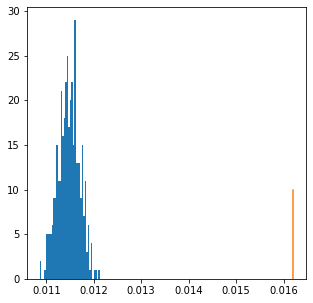

In [38]:
fig,ax = plt.subplots( 1, int((ndim*ndim+ndim)/2), figsize=(5*int((ndim*ndim+ndim)/2),5))

hbins = 40
hmax = 10

ai = 0

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        
        if ndim > 1 :
            thisax = ax[ai]
        else :
            thisax = ax

        thisax.hist( fit_results_cov_err[fi1,fi2,:], bins=hbins )
        thisax.plot( (rms_cov[fi1,fi2], rms_cov[fi1,fi2]), (0,hmax) )
        ai = ai + 1
    
plt.show

## Bootstrap error compared with average fit error

In [39]:
print('\n')

for fi in range(ndim) :
    
    print("  mean %d:  rms bootstraps %8.4f,  ave fit err %8.4f    ratio %6.2f |  val. %6.3f, true %6.3f, diff %6.3f"
         % (fi, rms_mean[fi], ave_fit_err_mean[fi], rms_mean[fi] / ave_fit_err_mean[fi], ave_mean[fi], true_mu[fi], ave_mean[fi]-true_mu[fi] ))
    
print('\n')

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        print("  cov%d%d:   rms bootstraps %8.4f,  ave fit err %8.4f    ratio %6.2f |  val. %6.3f, true %6.3f, diff %6.3f"
              % (fi1, fi2, rms_cov[fi1,fi2], ave_fit_err_cov[fi1,fi2], rms_cov[fi1,fi2]/ave_fit_err_cov[fi1,fi2], ave_cov[fi1,fi2], true_cov[fi1,fi2], ave_cov[fi1,fi2]-true_cov[fi1,fi2]) )
        

print('\n\n\n')

for fi in range(ndim) :
    
    print("  mean %d:  rms samples %8.4f +/- %6.4f,  ave fit err %8.4f    ratio %6.2f +/- %4.2f "
         % (fi, rms_mean[fi], rms_mean_err[fi],
            ave_fit_err_mean[fi], 
            rms_mean[fi] / ave_fit_err_mean[fi],
            rms_mean_err[fi] / ave_fit_err_mean[fi]))

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        print("  cov%d%d:   rms samples %8.4f +/- %6.4f,  ave fit err %8.4f    ratio %6.2f +/- %4.2f "
              % (fi1, fi2, rms_cov[fi1,fi2], rms_cov_err[fi1,fi2],
                 ave_fit_err_cov[fi1,fi2], 
                 rms_cov[fi1,fi2]/ave_fit_err_cov[fi1,fi2], rms_cov_err[fi1,fi2]/ave_fit_err_cov[fi1,fi2] ) )
        
print('\n')



  mean 0:  rms bootstraps   0.0122,  ave fit err   0.0090    ratio   1.36 |  val.  0.200, true  0.200, diff -0.000


  cov00:   rms bootstraps   0.0162,  ave fit err   0.0115    ratio   1.41 |  val.  0.813, true  0.810, diff  0.003




  mean 0:  rms samples   0.0122 +/- 0.0003,  ave fit err   0.0090    ratio   1.36 +/- 0.03 
  cov00:   rms samples   0.0162 +/- 0.0004,  ave fit err   0.0115    ratio   1.41 +/- 0.03 




## Look for outliers in feature coords and weights

In [40]:
for fi in range( ndim ) :
    
    print( "  feature %2d :  min %12f   max %12f " % ( fi, np.min(train_pts[:,fi]), np.max(train_pts[:,fi])) )

  feature  0 :  min    -4.899618   max     4.508435 


In [41]:
for si in range( n_samples ) :
    
    max_delta_mean = 0
    for fi in range(ndim) :
        delta = fit_results_mean_val[fi,si] - all_mean[fi,si] 
        if np.abs(delta) > max_delta_mean :
            max_delta_mean = delta
        
    print("  %3d : weight range  %12g  to %12f ,   max delta mean  %12f"
         % (si, all_weight_min[si], all_weight_max[si], max_delta_mean ))

    0 : weight range    0.00871729  to     0.126852 ,   max delta mean     -0.000004
    1 : weight range    0.00940894  to     0.121238 ,   max delta mean     -0.000001
    2 : weight range     0.0125768  to     0.126525 ,   max delta mean      0.000002
    3 : weight range    0.00583203  to     0.125372 ,   max delta mean      0.000010
    4 : weight range      0.006673  to     0.128409 ,   max delta mean     -0.000041
    5 : weight range    0.00406118  to     0.124662 ,   max delta mean      0.000048
    6 : weight range     0.0103077  to     0.124127 ,   max delta mean     -0.000010
    7 : weight range     0.0105447  to     0.131256 ,   max delta mean      0.000002
    8 : weight range    0.00826877  to     0.126439 ,   max delta mean     -0.000002
    9 : weight range     0.0135923  to     0.126174 ,   max delta mean     -0.000033
   10 : weight range      0.013363  to     0.124713 ,   max delta mean     -0.000006
   11 : weight range    0.00804108  to     0.126496 ,   max delta

IndexError: index 387 is out of bounds for axis 1 with size 387

## Look deeper into bootstrap with an outlier

In [ ]:
si = 35

fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, si)
            
with open(fname,'rb') as f :
            
    final_push_weights_scaled = np.load(f)

In [ ]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(final_push_weights_scaled), bins=hbins)
ax[1].hist( final_push_weights_scaled, bins=hbins)
ax[1].set_yscale('log')

plt.show

In [ ]:
selection_mask = final_push_weights_scaled < 100
train_pts_sel = train_pts[ selection_mask ]
weights_sel = final_push_weights_scaled[ selection_mask ]

print(" number of events before selection  %d" % len(train_pts))
print(" number of events passing selection %d" % len(train_pts_sel))
print(" max weight before selection : %f" % np.max(final_push_weights_scaled))
print(" max weight passing selection: %f" % np.max(weights_sel))

In [ ]:
for fi in range( ndim ) :
    
    fit_mean = fit_results_mean_val[fi,si]
    mean_all_evts = all_mean[fi,si]
    mean_sel = ( np.sum( weights_sel * train_pts_sel[:,fi]) ) / ( np.sum( weights_sel ) )
    mean_diff = mean_sel - mean_all_evts
    print(" %2d :  fit mean  %10f   mean all  %10f   selected  %10f   diff %10f  fit diff %10f" % 
          ( fi, fit_mean, mean_all_evts, mean_sel, mean_diff, (mean_sel-fit_mean) ))

## Look at outlier point

In [ ]:
train_pts_antisel = train_pts[ final_push_weights_scaled > 100 ]
train_pts_antisel.shape

In [ ]:
for fi in range( ndim ) :
    
    sigma = np.sqrt(ave_cov[fi,fi])
    
    print(" %2d :  val %10f   mean %10f   sigma %10f  diff/sigma %10f" %
          (fi, train_pts_antisel[0,fi], ave_mean[fi], sigma, (train_pts_antisel[0,fi]-ave_mean[fi])/sigma )
         )

In [ ]:
true_sig

## Calculate the true weights and compare with unfolding weights